In [142]:
#importando as bibliotecas
import numpy as np
from sklearn.datasets import make_blobs, make_moons, make_circles
import problexity as px
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [143]:
# Configuração das bases sintéticas geradas
datasets_config = {
    "blobs": {
        "n_classes": [2, 3, 4],
        "n_features": [2, 4, 8, 16],
        "samples_per_class": [50, 500],
        "noise_levels": {"no_noise": 2, "low_noise": 5, "high_noise": 8}
    },
    "moons": {
        "samples_per_class": [(50,50), (500,500)],
        "noise_levels": {"no_noise": 0.0, "low_noise": 0.2, "high_noise": 0.4}
    },
    "circles": {
        "samples_per_class": [(50,50), (500,500)],
        "noise_levels": {"no_noise": 0.0, "low_noise": 0.10, "high_noise": 0.20}
    },
    "xor": {
        "samples_per_class": [50, 500],
        "noise_levels": {"no_noise": 0.1, "low_noise": 0.25, "high_noise": 0.4}
    }
}

# Função para gerar os centróides dos clusters para os blobs
# cada classe tem um centróide, e cada centróide deve ser equidistânte entre si, com distância d entre eles
# para 2 features e 2 classes, com d = 10, o centróide da segunda classe deve ser (10.0, 0.0) e o da primeira (0.0, 0.0)
# para 2 features e 4 classes, não é possível ter esses centróides equidistantes, então vamos assumir uma topologia igual ao de um quadrado
# para outras configurações essa restrição não é imposta, e a topologia vai ser ou um triângulo equilátero ou um tetraedro regular ou apenas um segmento de reta
def generate_regular_simplex(k_classes, distance=15.0):
    """
    Gera um simplex regular com k_classes pontos em (k_classes-1) dimensões.
    Retorna um array com as coordenadas dos centróides.
    """
    m = k_classes - 1  # Dimensões necessárias para o simplex
    points = np.zeros((k_classes, m))
    
    if m == 0:
        return points  # Caso trivial (1 cluster)
    
    # Primeiro ponto na origem
    # Segundo ponto em (distance, 0, ..., 0)
    points[1, 0] = distance
    
    # Pontos subsequentes
    for i in range(2, k_classes):
        centroid = np.mean(points[:i], axis=0)
        dist_centroid_to_origin = np.linalg.norm(centroid - points[0])
        h = np.sqrt(distance**2 - dist_centroid_to_origin**2)
        points[i, :i-1] = centroid[:i-1]
        points[i, i-1] = h
    
    return points

def generate_centroids(k_classes, n_features, distance=15.0):
    """
    Gera centróides com distância fixa de 15 unidades.
    Retorna um array (k_classes, n_features).
    """
    if k_classes > n_features + 1:

        centroids = [np.zeros(n_features, dtype = np.float64) for _ in range(k_classes)]
        # Quadrado
        centroids[1][0] = 10.0
        centroids[2][1] = 10.0
        centroids[3][0] = 10.0
        centroids[3][1] = 10.0
    
    else:
        # Gera o simplex em (k_classes-1) dimensões
        simplex = generate_regular_simplex(k_classes, distance)

        # Preenche com zeros para alcançar n_features dimensões
        centroids = np.zeros((k_classes, n_features))
        centroids[:, :simplex.shape[1]] = simplex

    return centroids


In [144]:
# o scikit-lear não tem suporte para gerar bases tipo XOR, então implementamos uma função semelhante para gerar esses dados

def generate_xor(n_samples_per_class, noise_std=0.0, random_state=None):
    """Gera dados no formato XOR com ruído Gaussiano."""
    rng = np.random.default_rng(random_state)
    # Classe 0: (0,0) e (1,1)
    X0_1 = rng.normal(loc=(0, 0), scale=noise_std, size=(n_samples_per_class // 2, 2))
    X0_2 = rng.normal(loc=(1, 1), scale=noise_std, size=(n_samples_per_class - n_samples_per_class // 2, 2))
    X0 = np.vstack([X0_1, X0_2])
    # Classe 1: (0,1) e (1,0)
    X1_1 = rng.normal(loc=(0, 1), scale=noise_std, size=(n_samples_per_class // 2, 2))
    X1_2 = rng.normal(loc=(1, 0), scale=noise_std, size=(n_samples_per_class - n_samples_per_class // 2, 2))
    X1 = np.vstack([X1_1, X1_2])
    X = np.vstack([X0, X1])
    y = np.hstack([np.zeros(n_samples_per_class), np.ones(n_samples_per_class)])
    return X, y

In [145]:
print(generate_centroids(4, 5, 10.0))

[[ 0.          0.          0.          0.          0.        ]
 [10.          0.          0.          0.          0.        ]
 [ 5.          8.66025404  0.          0.          0.        ]
 [ 5.          2.88675135  8.16496581  0.          0.        ]]


In [146]:
# gerando os datasets sintéticos para blobs
i = 0

for n_classes in datasets_config["blobs"]["n_classes"]:
    for n_features in datasets_config["blobs"]["n_features"]:
        for samples_per_class in datasets_config["blobs"]["samples_per_class"]:
            for noise_level_name, noise_level in datasets_config["blobs"]["noise_levels"].items():

                # Gerar os dados
                X, y = make_blobs(n_samples=n_classes * samples_per_class, centers=generate_centroids(n_classes, n_features, 20.0), n_features=n_features, cluster_std=noise_level, random_state= 42+i)
                
                # Criar DataFrame
                df = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(n_features)])
                df['target'] = y
                
                # Salvar o DataFrame em um arquivo CSV
                filename = f"blobs_datasets/blobs_{n_classes}classes_{n_features}features_{samples_per_class}samples_{noise_level_name}.csv"
                df.to_csv(filename, index=False)

                i += 1

In [147]:
# gerando os datasets sintéticos para moons
i = 0

for samples_per_class in datasets_config["moons"]["samples_per_class"]:
    for noise_level_name, noise_level in datasets_config["moons"]["noise_levels"].items():

        # Gerar os dados
        X, y = make_moons(n_samples=samples_per_class, noise=noise_level, random_state= 70+i)
        
        # Criar DataFrame
        df = pd.DataFrame(X, columns=["feature_1", "feature_2"])
        df['target'] = y
        
        # Salvar o DataFrame em um arquivo CSV
        filename = f"moons_datasets/moons_{samples_per_class[0]}samples_{noise_level_name}.csv"
        df.to_csv(filename, index=False)

        i += 1

In [148]:
# gerando os datasets sintéticos para circles
i = 0

for samples_per_class in datasets_config["circles"]["samples_per_class"]:
    for noise_level_name, noise_level in datasets_config["circles"]["noise_levels"].items():

        # Gerar os dados
        X, y = make_circles(n_samples=samples_per_class, noise=noise_level, random_state= 100+i)
        
        # Criar DataFrame
        df = pd.DataFrame(X, columns=["feature_1", "feature_2"])
        df['target'] = y
        
        # Salvar o DataFrame em um arquivo CSV
        filename = f"circles_datasets/circles_{samples_per_class[0]}samples_{noise_level_name}.csv"
        df.to_csv(filename, index=False)

        i += 1

In [149]:
# gerando os datasets sintéticos para xor
i = 0

for samples_per_class in datasets_config["xor"]["samples_per_class"]:
    for noise_level_name, noise_level in datasets_config["xor"]["noise_levels"].items():

        # Gerar os dados
        X, y = generate_xor(samples_per_class, noise_std=noise_level, random_state= 130+i)
        
        # Criar DataFrame
        df = pd.DataFrame(X, columns=["feature_1", "feature_2"])
        df['target'] = y
        
        # Salvar o DataFrame em um arquivo CSV
        filename = f"xor_datasets/xor_{samples_per_class}samples_{noise_level_name}.csv"
        df.to_csv(filename, index=False)

        i += 1

In [150]:
# plotando alguns datasets com 2 features

def plot_blobs_datasets(df, n_classes, n_features, samples_per_class, noise_level_name):

    plt.figure(figsize=(8, 6))
    plt.title(f"Blobs: {n_classes} classes, {n_features} features, {samples_per_class} samples, {noise_level_name}")
    plt.scatter(df['feature_0'], df['feature_1'], c=df['target'], cmap='viridis', s=30)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.grid(True)
    plt.savefig(f"blobs_plot/blobs_{n_classes}classes_{n_features}features_{samples_per_class}samples_{noise_level_name}.png")
    plt.show()
    plt.close()

def plot_moons_datasets(df, samples_per_class, noise_level_name):
    
    plt.figure(figsize=(8, 6))
    plt.title(f"Moons: {samples_per_class[0]} samples, {noise_level_name}")
    plt.scatter(df['feature_1'], df['feature_2'], c=df['target'], cmap='viridis', s=30)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.grid(True)
    plt.savefig(f"moons_plot/moons_{samples_per_class[0]}samples_{noise_level_name}.png")
    plt.show()
    plt.close()

def plot_circles_datasets(df, samples_per_class, noise_level_name):
    
    plt.figure(figsize=(8, 6))
    plt.title(f"Circles: {samples_per_class} samples, {noise_level_name}")
    plt.scatter(df['feature_1'], df['feature_2'], c=df['target'], cmap='viridis', s=30)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.grid(True)
    plt.savefig(f"circles_plot/circles_{samples_per_class}samples_{noise_level_name}.png")
    plt.show()
    plt.close()

def plot_xor_datasets(df, samples_per_class, noise_level_name):

    plt.figure(figsize=(8, 6))
    plt.title(f"XOR: {samples_per_class} samples, {noise_level_name}")
    plt.scatter(df['feature_1'], df['feature_2'], c=df['target'], cmap='viridis', s=30)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.grid(True)
    plt.savefig(f"xor_plot/xor_{samples_per_class}samples_{noise_level_name}.png")
    plt.show()
    plt.close()

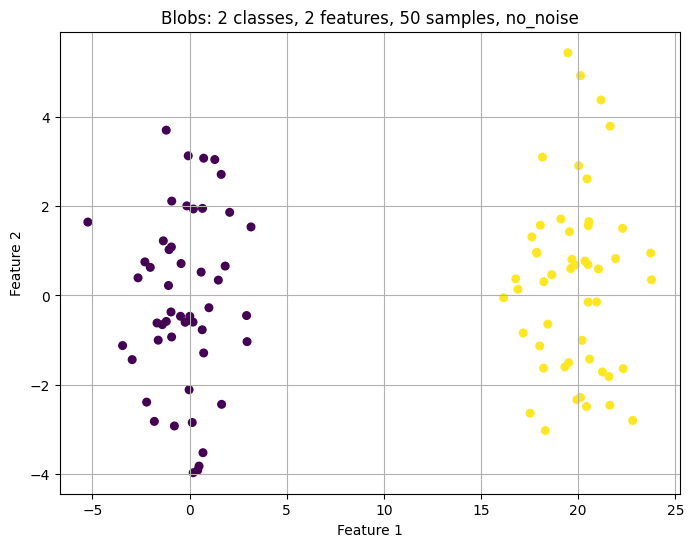

In [151]:
df = pd.read_csv("blobs_datasets/blobs_2classes_2features_50samples_no_noise.csv")
plot_blobs_datasets(df, 2, 2, 50, "no_noise")

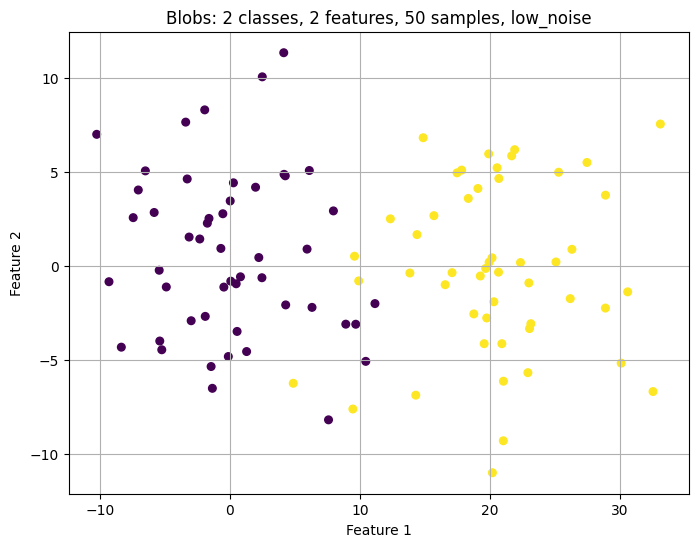

In [152]:
df = pd.read_csv("blobs_datasets/blobs_2classes_2features_50samples_low_noise.csv")
plot_blobs_datasets(df, 2, 2, 50, "low_noise")

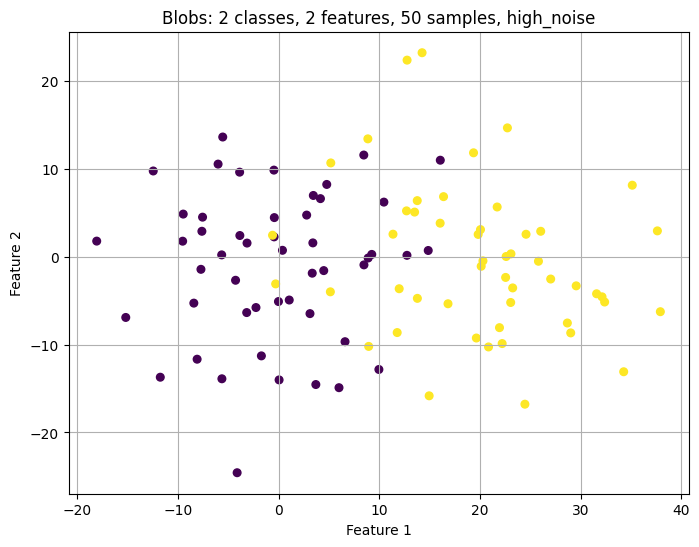

In [153]:
df = pd.read_csv("blobs_datasets/blobs_2classes_2features_50samples_high_noise.csv")
plot_blobs_datasets(df, 2, 2, 50, "high_noise")

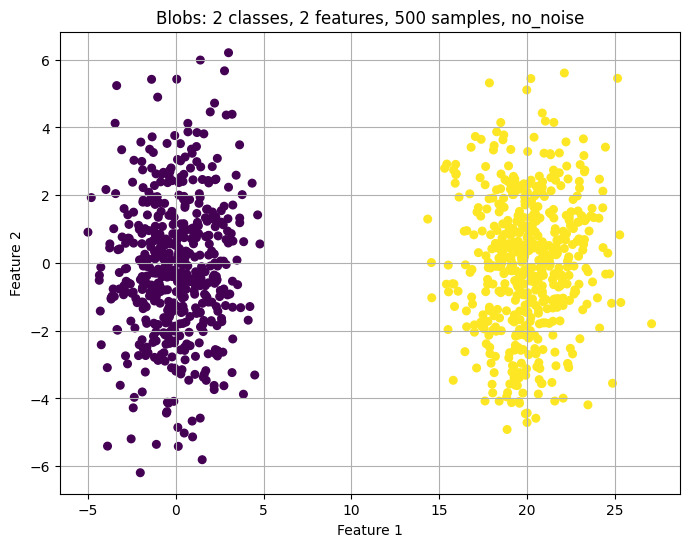

In [154]:
df = pd.read_csv("blobs_datasets/blobs_2classes_2features_500samples_no_noise.csv")
plot_blobs_datasets(df, 2, 2, 500, "no_noise")

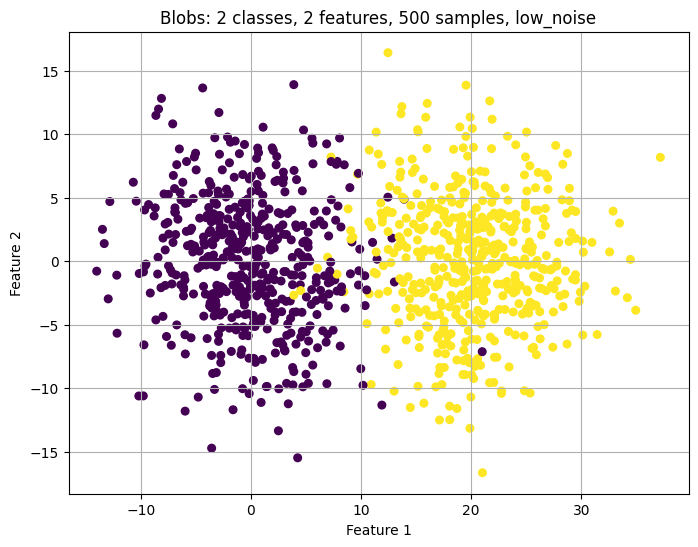

In [155]:
df = pd.read_csv("blobs_datasets/blobs_2classes_2features_500samples_low_noise.csv")
plot_blobs_datasets(df, 2, 2, 500, "low_noise")

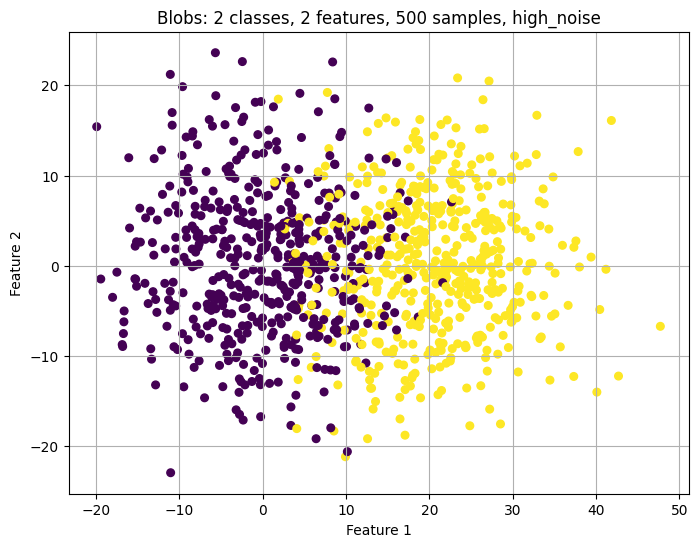

In [156]:
df = pd.read_csv("blobs_datasets/blobs_2classes_2features_500samples_high_noise.csv")
plot_blobs_datasets(df, 2, 2, 500, "high_noise")

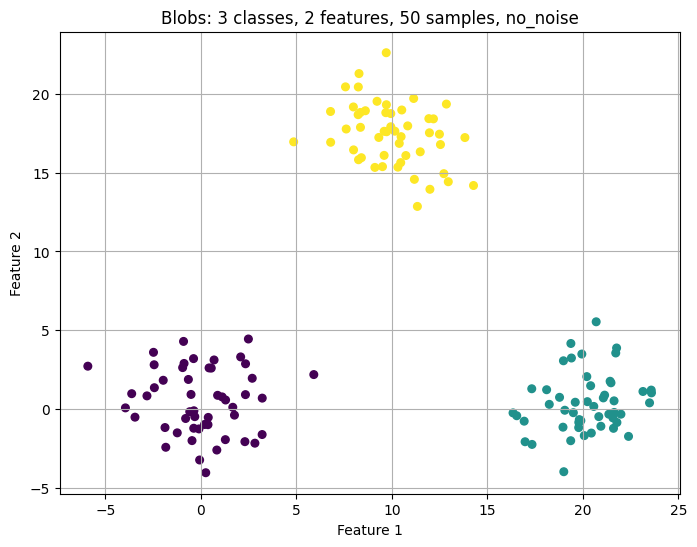

In [157]:
df = pd.read_csv("blobs_datasets/blobs_3classes_2features_50samples_no_noise.csv")
plot_blobs_datasets(df, 3, 2, 50, "no_noise")

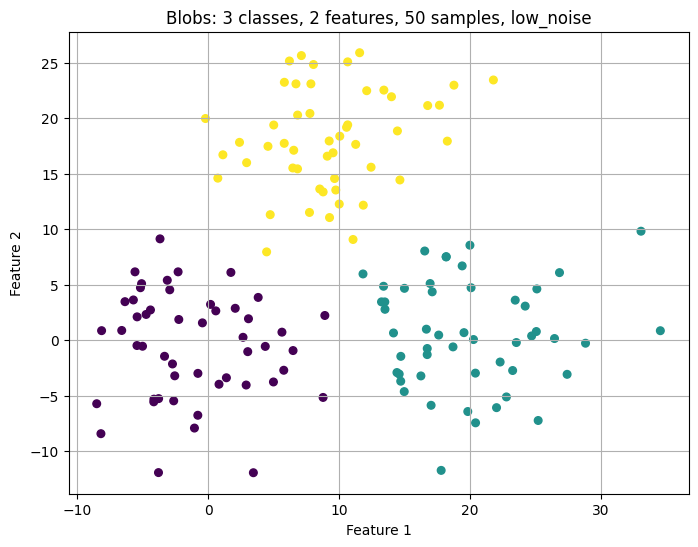

In [158]:
df = pd.read_csv("blobs_datasets/blobs_3classes_2features_50samples_low_noise.csv")
plot_blobs_datasets(df, 3, 2, 50, "low_noise")

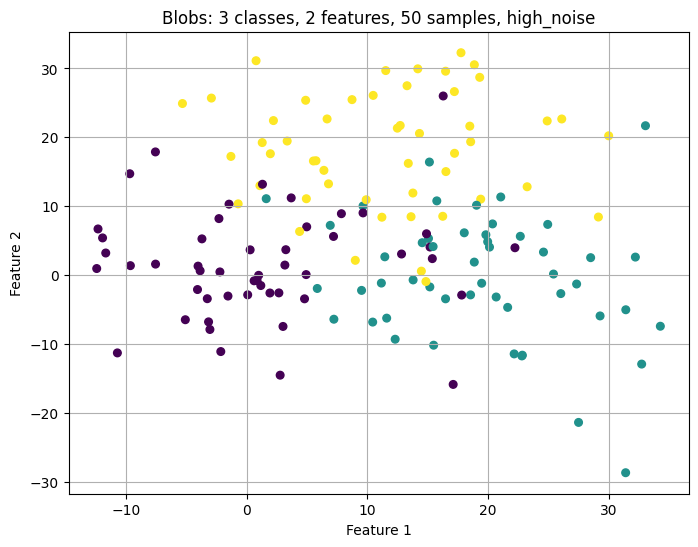

In [159]:
df = pd.read_csv("blobs_datasets/blobs_3classes_2features_50samples_high_noise.csv")
plot_blobs_datasets(df, 3, 2, 50, "high_noise")

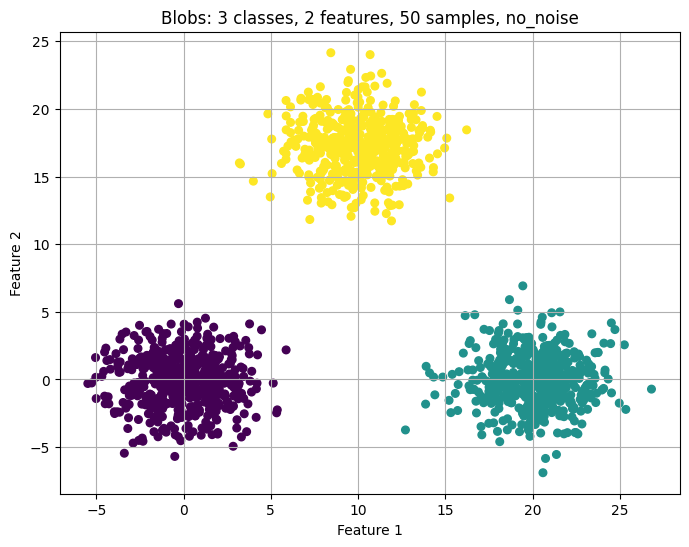

In [160]:
df = pd.read_csv("blobs_datasets/blobs_3classes_2features_500samples_no_noise.csv")
plot_blobs_datasets(df, 3, 2, 50, "no_noise")

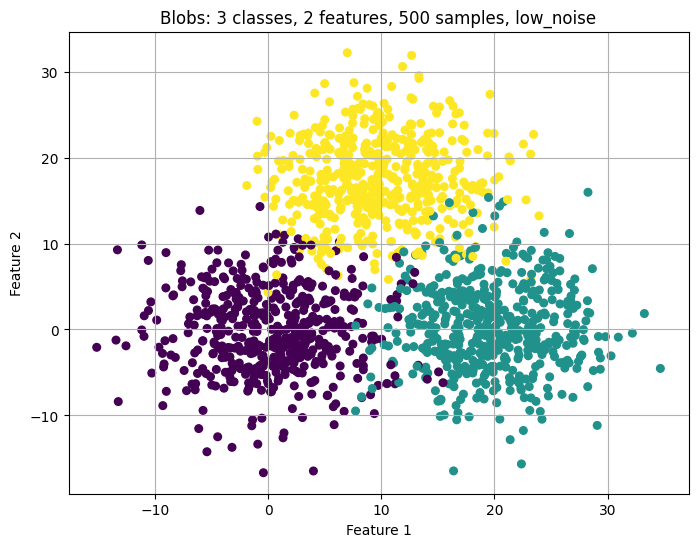

In [161]:
df = pd.read_csv("blobs_datasets/blobs_3classes_2features_500samples_low_noise.csv")
plot_blobs_datasets(df, 3, 2, 500, "low_noise")

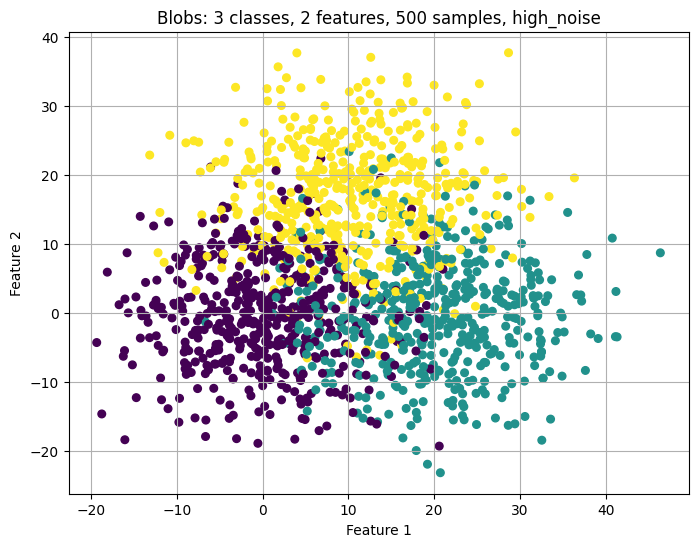

In [162]:
df = pd.read_csv("blobs_datasets/blobs_3classes_2features_500samples_high_noise.csv")
plot_blobs_datasets(df, 3, 2, 500, "high_noise")

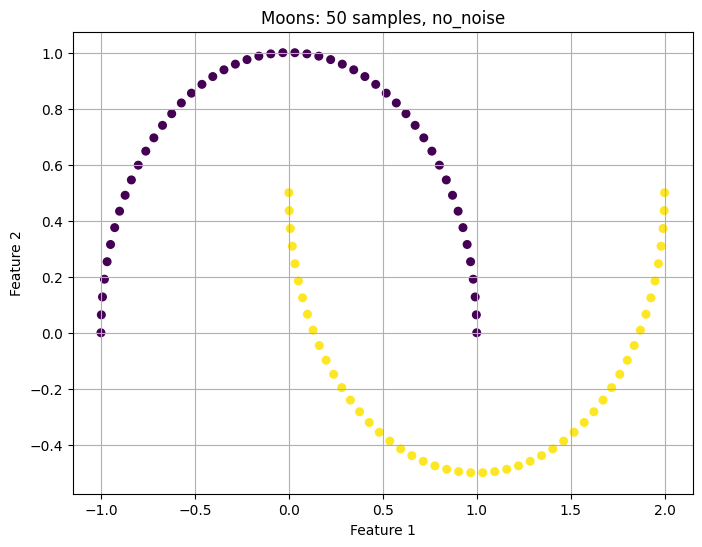

In [163]:
df = pd.read_csv("moons_datasets/moons_50samples_no_noise.csv")
plot_moons_datasets(df, (50,50), "no_noise")

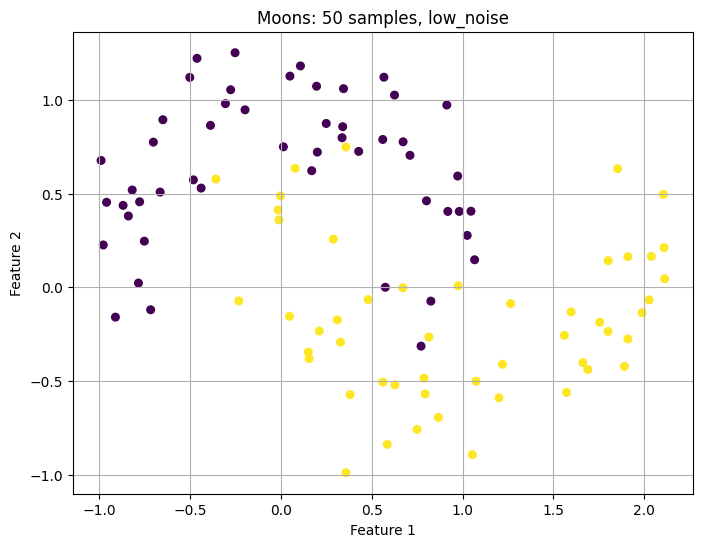

In [164]:
df = pd.read_csv("moons_datasets/moons_50samples_low_noise.csv")
plot_moons_datasets(df, (50,50), "low_noise")

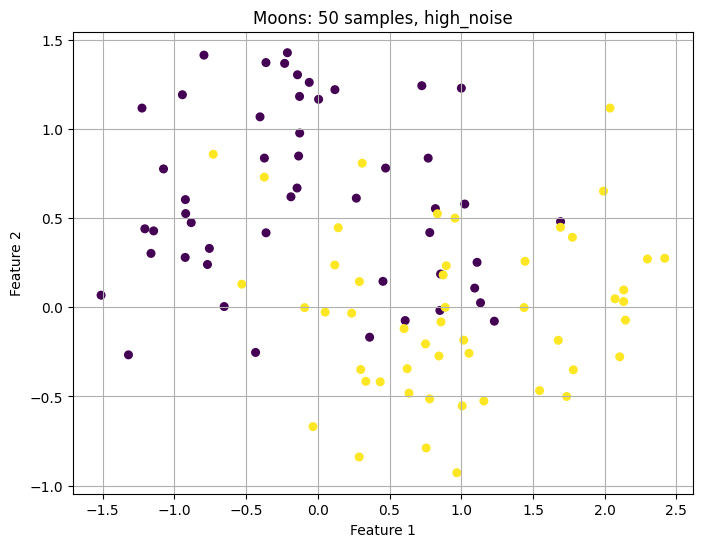

In [165]:
df = pd.read_csv("moons_datasets/moons_50samples_high_noise.csv")
plot_moons_datasets(df, (50,50), "high_noise")

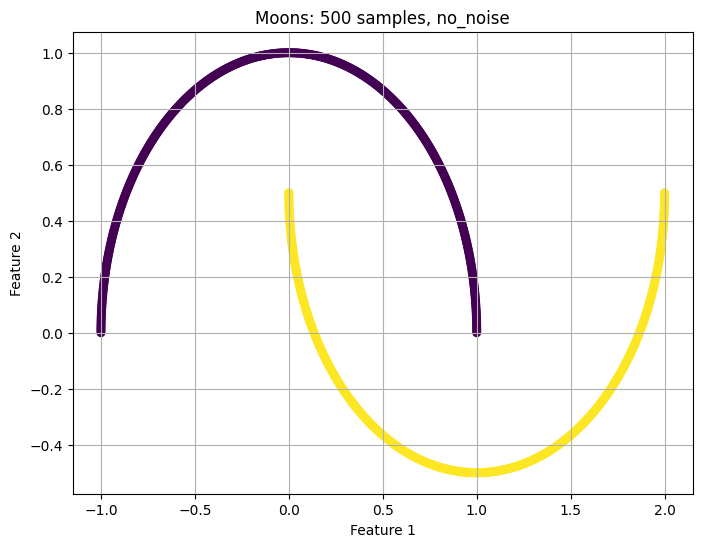

In [166]:
df = pd.read_csv("moons_datasets/moons_500samples_no_noise.csv")
plot_moons_datasets(df, (500,500), "no_noise")

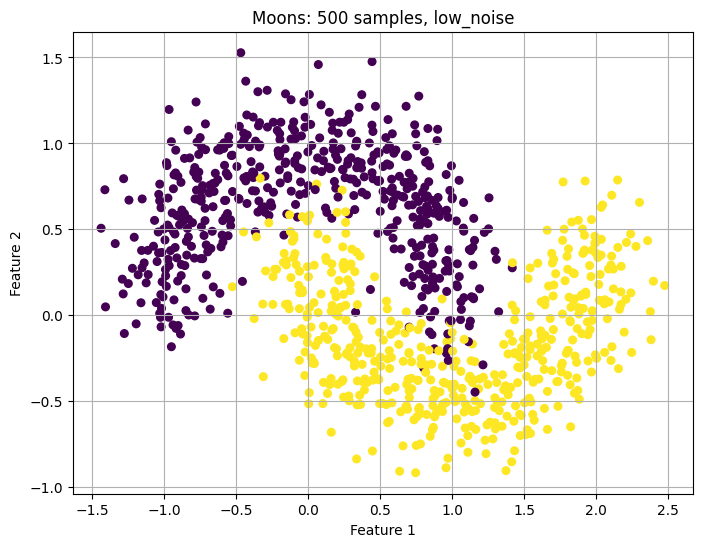

In [167]:
df = pd.read_csv("moons_datasets/moons_500samples_low_noise.csv")
plot_moons_datasets(df, (500,500), "low_noise")

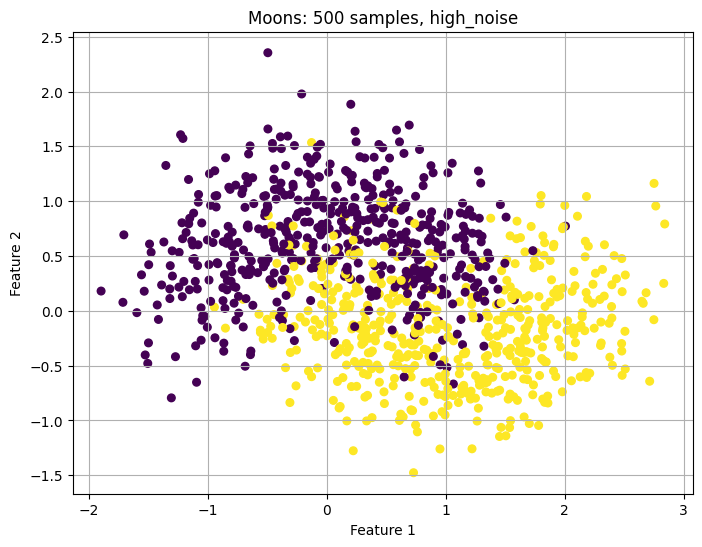

In [168]:
df = pd.read_csv("moons_datasets/moons_500samples_high_noise.csv")
plot_moons_datasets(df, (500,500), "high_noise")

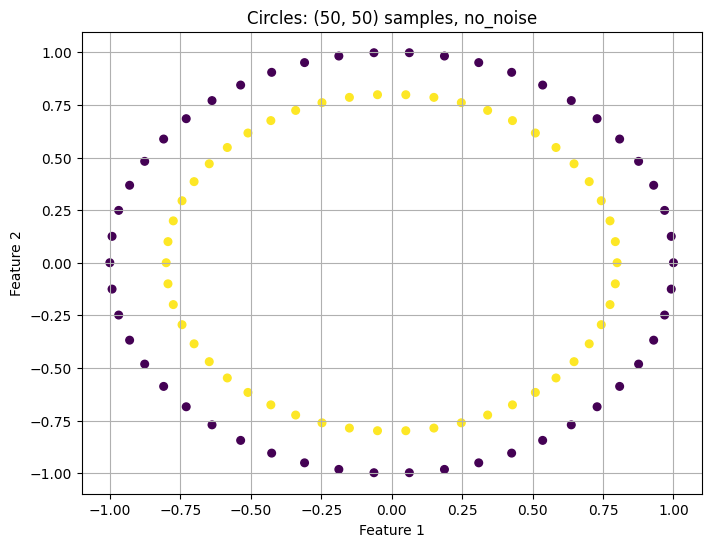

In [169]:
df = pd.read_csv("circles_datasets/circles_50samples_no_noise.csv")
plot_circles_datasets(df, (50,50), "no_noise")

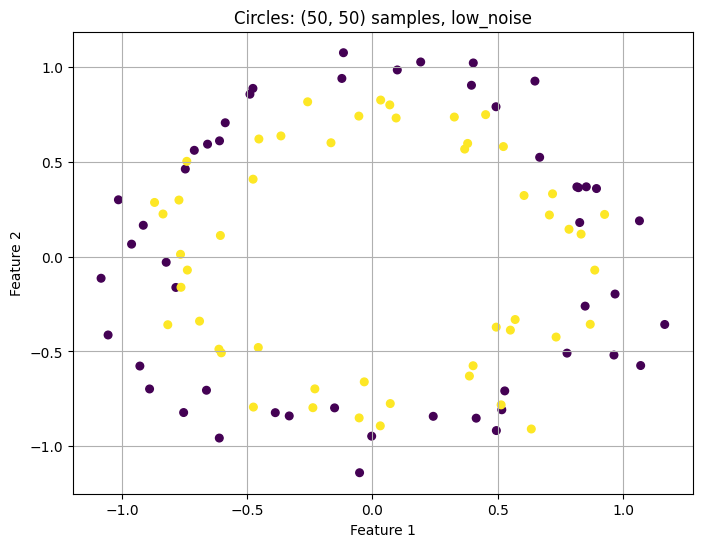

In [170]:
df = pd.read_csv("circles_datasets/circles_50samples_low_noise.csv")
plot_circles_datasets(df, (50,50), "low_noise")

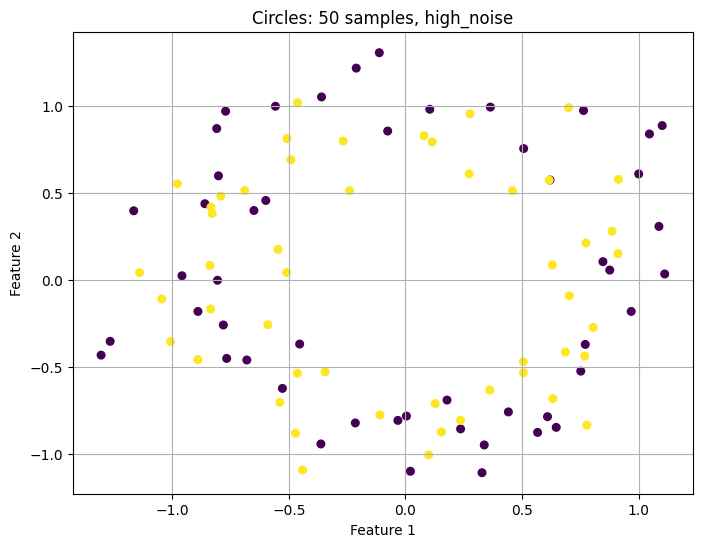

In [171]:
df = pd.read_csv("circles_datasets/circles_50samples_high_noise.csv")
plot_circles_datasets(df, 50, "high_noise")

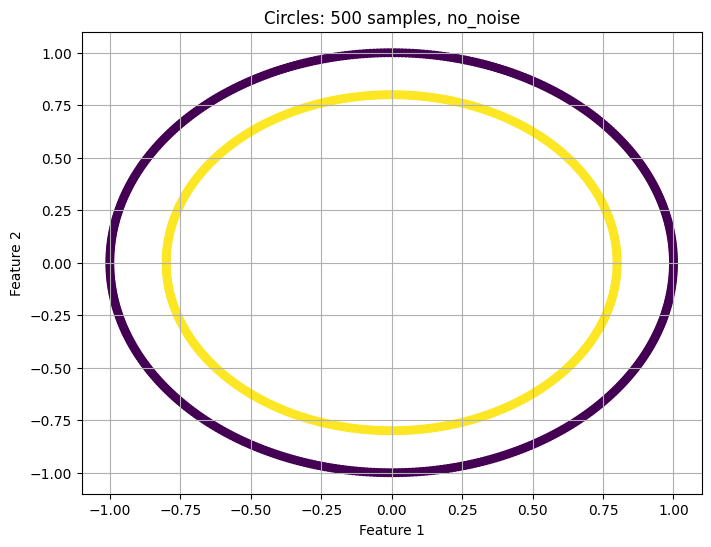

In [172]:
df = pd.read_csv("circles_datasets/circles_500samples_no_noise.csv")
plot_circles_datasets(df, 500, "no_noise")

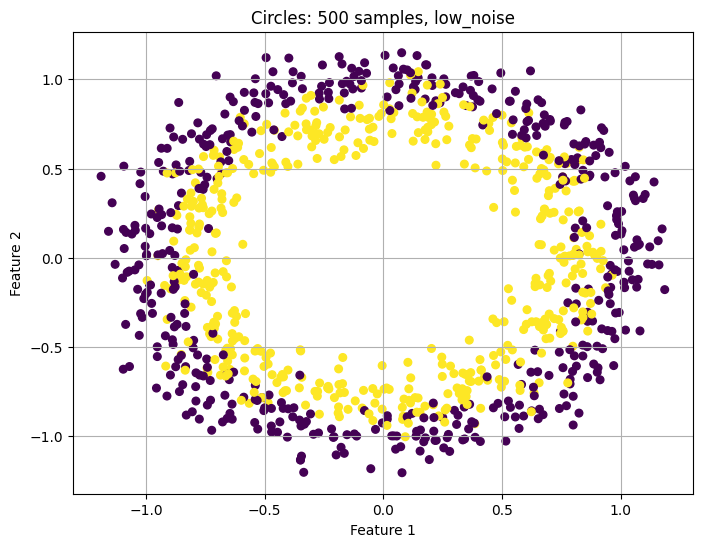

In [173]:
df = pd.read_csv("circles_datasets/circles_500samples_low_noise.csv")
plot_circles_datasets(df, 500, "low_noise")

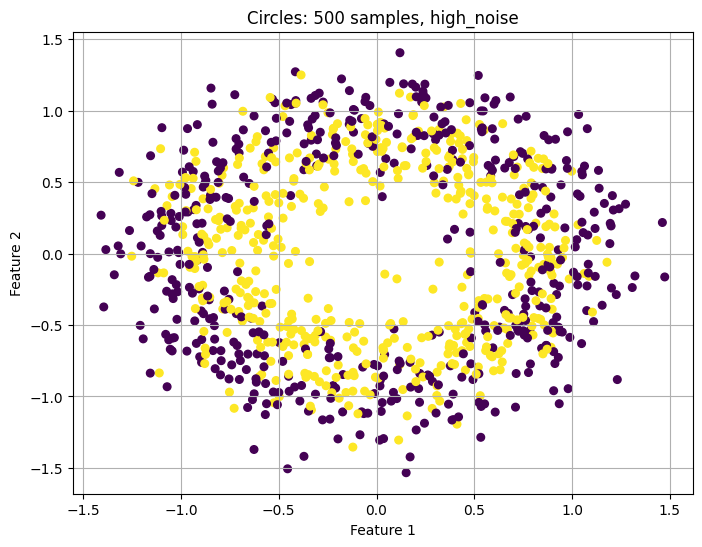

In [174]:
df = pd.read_csv("circles_datasets/circles_500samples_high_noise.csv")
plot_circles_datasets(df, 500, "high_noise")

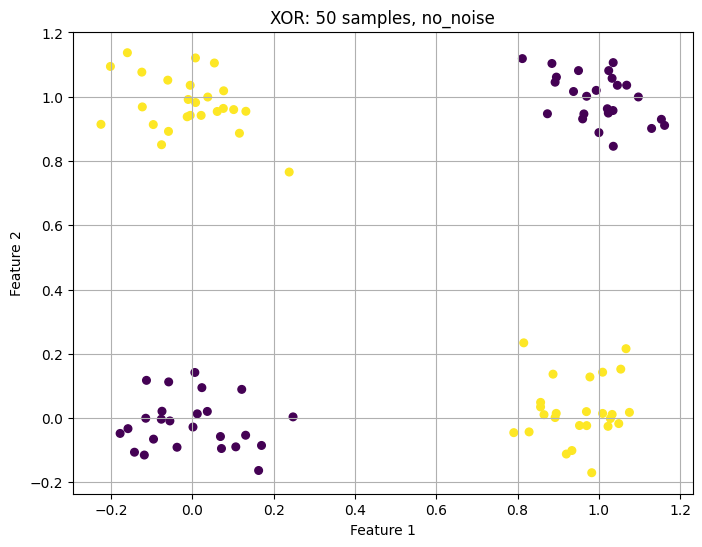

In [175]:
df = pd.read_csv("xor_datasets/xor_50samples_no_noise.csv")
plot_xor_datasets(df, 50, "no_noise")

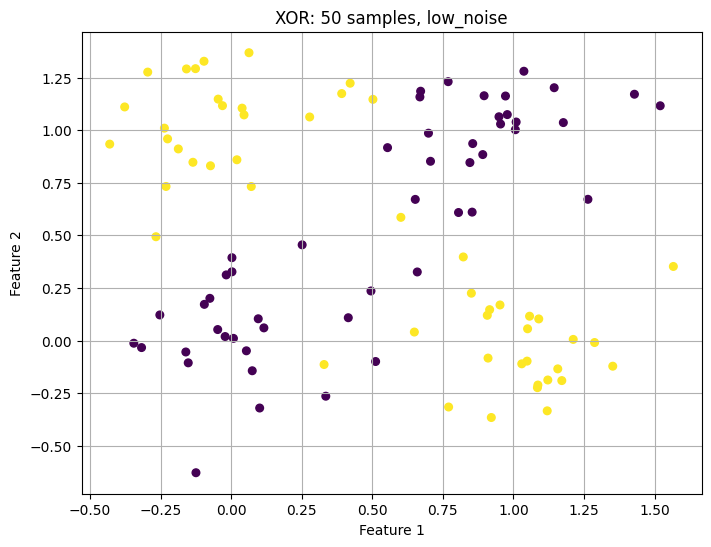

In [176]:
df = pd.read_csv("xor_datasets/xor_50samples_low_noise.csv")
plot_xor_datasets(df, 50, "low_noise")

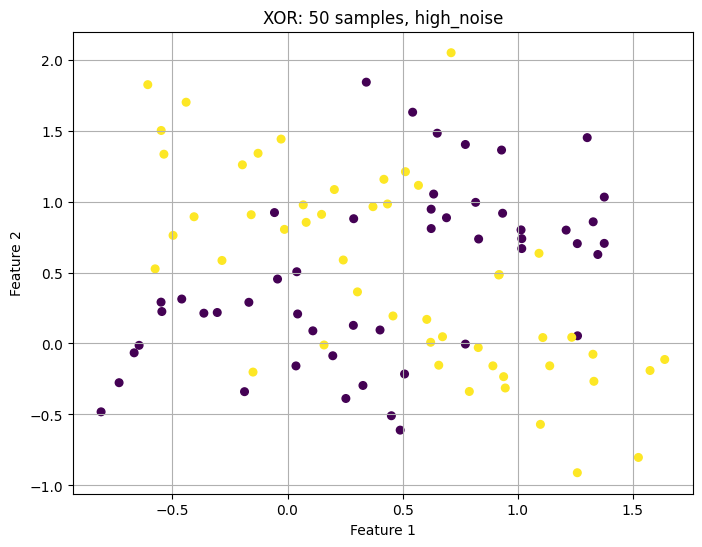

In [177]:
df = pd.read_csv("xor_datasets/xor_50samples_high_noise.csv")
plot_xor_datasets(df, 50, "high_noise")

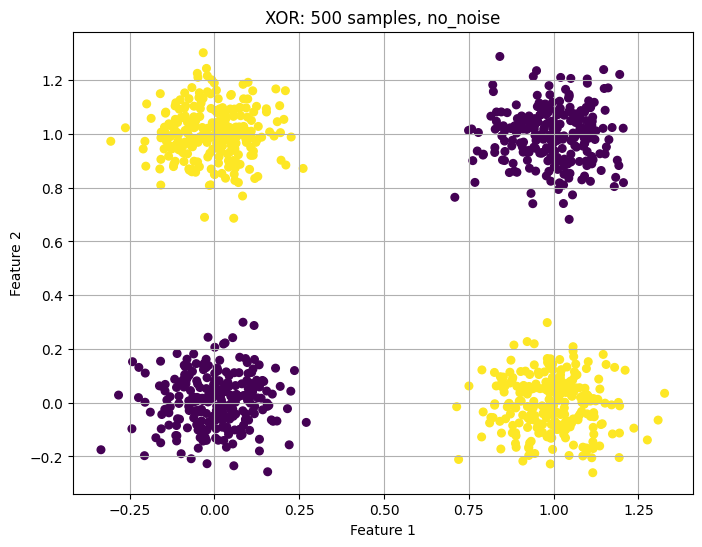

In [178]:
df = pd.read_csv("xor_datasets/xor_500samples_no_noise.csv")
plot_xor_datasets(df, 500, "no_noise")

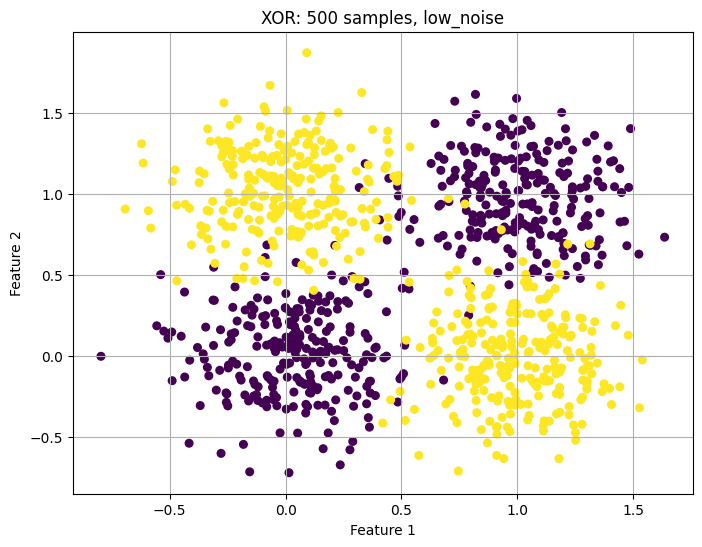

In [179]:
df = pd.read_csv("xor_datasets/xor_500samples_low_noise.csv")
plot_xor_datasets(df, 500, "low_noise")

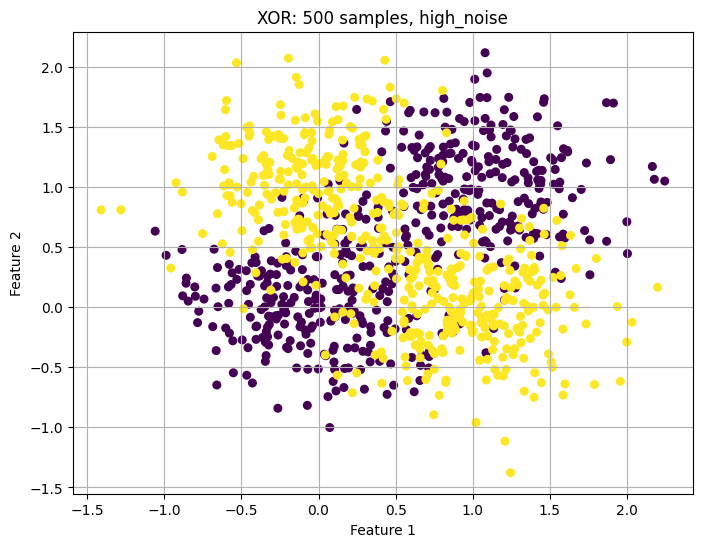

In [180]:
df = pd.read_csv("xor_datasets/xor_500samples_high_noise.csv")
plot_xor_datasets(df, 500, "high_noise")

In [200]:
# calcular as métricas de descrição dos datasets sintéticos

def generation_metrics(df, df_name, path_file, sample_size=0.7, sample_balanced=True,random_state=42):

    """
    Calcula as métricas de descrição dos datasets sintéticos.
    seed primária irá gerar 30 seeds diferentes que serão utilizadas para criar amostras com 70% de cada dataset
    e calcular as métricas de descrição.
    As métricas de descrição são: "f1", "f1v", "f2", "f3", "f4", "l1", "l2", "l3", "n1", "n2", "n3", "n4", "t1", "lsc",
    "density", "clsCoef", "hubs", "t2", "t3", "t4", "c1", "c2".
    As métricas de descrição são calculadas utilizando a biblioteca problexity.
    sample_balanced vai indicar se as amostras devem ser balanceadas de acordo com as classes ou não.
    """
    cc = px.ComplexityCalculator()

    df_nclass = df['target'].nunique()


    seed_gen = np.random.default_rng(random_state)

    # Gerar 30 seeds diferentes para amostras de 70% do dataset
    seeds = seed_gen.integers(low=0, high=1000000, size=30)

    # armazenar os resultados
    f1 = []
    f1v = []
    f2 = []
    f3 = []
    f4 = []
    l1 = []
    l2 = []
    l3 = []
    n1 = []
    n2 = []
    n3 = []
    n4 = []
    t1 = []
    lsc = []
    density = []
    clsCoef = []
    hubs = []
    t2 = []
    t3 = []
    t4 = []
    c1 = []
    c2 = []
    samples = []

    # armazenar os índices das classes para amostras balanceadas
    if sample_balanced:

        class_index = []

        for i in range(df_nclass):

            aux = df[df['target'] == i].index.tolist()

            class_index.append(aux)

    # se não for amostras balanceadas, pegar os índices de todas as classes
    else:
        class_index = df.index.tolist()

    # calcular as métricas de descrição do dataset para cada seed
    for seed in seeds:

        rng = np.random.default_rng(seed)

        sample = []

        for index_list in class_index:

            # amostra de 70% do dataset
            sample.append(rng.choice(index_list, size=int(len(index_list)*sample_size), replace=False))

        sample = np.concatenate(sample)

        # armazenando as amostras para possíveis comparações futuras
        samples.append(sample)

        x = df.loc[sample,  df.columns != "target"]
        x = x.to_numpy()

        y = df.loc[sample, "target"]
        y = y.values.flatten()

        # ajustando o modelo com os dados
        cc.fit(x, y)

        metrics = cc.complexity

        # armazenando as métricas de descrição
        f1.append(metrics[0])
        f1v.append(metrics[1])
        f2.append(metrics[2])
        f3.append(metrics[3])
        f4.append(metrics[4])
        l1.append(metrics[5])
        l2.append(metrics[6])
        l3.append(metrics[7])
        n1.append(metrics[8])
        n2.append(metrics[9])
        n3.append(metrics[10])
        n4.append(metrics[11])
        t1.append(metrics[12])
        lsc.append(metrics[13])
        density.append(metrics[14])
        clsCoef.append(metrics[15])
        hubs.append(metrics[16])
        t2.append(metrics[17])
        t3.append(metrics[18])
        t4.append(metrics[19])
        c1.append(metrics[20])
        c2.append(metrics[21])

    # armazenar tudo em um dicionário e salvar usando pickle
    results = {
        "arquivo": df_name,
        "seed_primária": random_state,
        "seeds": seeds,
        "samples": samples,
        "f1": f1,
        "f1v": f1v,
        "f2": f2,
        "f3": f3,
        "f4": f4,
        "l1": l1,
        "l2": l2,
        "l3": l3,
        "n1": n1,
        "n2": n2,
        "n3": n3,
        "n4": n4,
        "t1": t1,
        "lsc": lsc,
        "density": density,
        "clsCoef": clsCoef,
        "hubs": hubs,
        "t2": t2,
        "t3": t3,
        "t4": t4,
        "c1": c1,
        "c2": c2
    }

    #salvando em um arquivo .pkl

    with open(path_file, 'wb') as file:
        pickle.dump(results, file)

    print(f"Arquivo {df_name} salvo em {path_file}")

    return results

    
    

In [182]:
df = pd.read_csv("blobs_datasets/blobs_2classes_2features_50samples_no_noise.csv")
resultado = generation_metrics(df, "blobs_2classes_2features_50samples_no_noise", "blobs_metrics/blobs_2classes_2features_50samples_no_noise.pkl", sample_size=0.7, sample_balanced=True, random_state=42)

Arquivo blobs_2classes_2features_50samples_no_noise salvo em blobs_metrics/blobs_2classes_2features_50samples_no_noise.pkl


In [183]:
#gerar as métricas para todos os datasets de uma determinada pasta
import os

def processar_datasets_em_pasta(pasta_csv, pasta_saida, sample_size=0.7, sample_balanced=True, random_state=42):

    # Garante que a pasta de saída existe
    os.makedirs(pasta_saida, exist_ok=True)

    # Percorre todos os arquivos na pasta
    for nome_arquivo in os.listdir(pasta_csv):
        if nome_arquivo.endswith(".csv"):
            caminho_csv = os.path.join(pasta_csv, nome_arquivo)
            
            # Carrega o dataset
            df = pd.read_csv(caminho_csv)
            
            # Gera nome base (sem extensão)
            nome_base = os.path.splitext(nome_arquivo)[0]
            
            # Define caminho do arquivo .pkl de saída
            caminho_saida = os.path.join(pasta_saida, f"{nome_base}.pkl")
            
            # Chama a função com os parâmetros desejados
            resultado = generation_metrics(
                df=df,
                df_name=nome_base,
                path_file=caminho_saida,
                sample_size=sample_size,
                sample_balanced=sample_balanced,
                random_state=random_state
            )
            random_state += 1  # Incrementa a seed primária para o próximo arquivo
            



In [ ]:
processar_datasets_em_pasta("blobs_datasets", "blobs_metrics", sample_size=0.7, sample_balanced=True, random_state=42)

In [ ]:
processar_datasets_em_pasta("moons_datasets", "moons_metrics", sample_size=0.7, sample_balanced=True, random_state=42)

In [ ]:
processar_datasets_em_pasta("circles_datasets", "circles_metrics", sample_size=0.7, sample_balanced=True, random_state=42)

In [ ]:
processar_datasets_em_pasta("xor_datasets", "xor_metrics", sample_size=0.7, sample_balanced=True, random_state=42)

In [188]:
#exemplo para carregar as informações das métricas

with open("blobs_metrics/blobs_2classes_2features_50samples_no_noise.pkl", 'rb') as file:
    metrics = pickle.load(file)


In [189]:
# gerando métricas para bases reais
from sklearn.datasets import load_iris
x, y = load_iris(return_X_y=True)

# transformar os dados em um dataframe
df = pd.DataFrame(x, columns=[f"feature_{i}" for i in range(x.shape[1])])
df['target'] = y

In [190]:
df.head()

,feature_0,feature_1,feature_2,feature_3,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [191]:
generation_metrics(df, "iris", "bases_reais_metrics/iris.pkl", sample_size=0.7, sample_balanced=True, random_state=79)

Arquivo iris salvo em bases_reais_metrics/iris.pkl


{'arquivo': 'iris',
 'seed_primária': 79,
 'seeds': array([107116, 919602, 888246,  71622, 986799, 923081, 320251,  35746,
        613813,  87471, 865606, 125702, 150047, 477700, 703540, 374995,
        736634, 103311, 607508, 621314, 724967, 511756, 798830, 618805,
         83873, 111187, 923560,  41316, 954252, 953503]),
 'samples': [array([ 28,  23,  19,  17,  10,  32,  33,   2,   0,  20,  29,  21,  46,
          27,  25,   4,  14,  34,  31,  30,  41,   3,  12,  49,  39,   8,
          47,  37,  40,  26,   1,   7,  22,  42,   6,  63,  75,  65,  78,
          68,  84,  71,  97,  59,  77,  80,  61,  72,  73,  53,  85,  82,
          95,  69,  56,  51,  58,  92,  79,  67,  93,  86,  96,  87,  94,
          74,  99,  50,  52,  81, 147, 117, 141, 125, 113, 102, 126, 148,
         139, 108, 138, 144, 104, 140, 131, 105, 130, 115, 119, 142, 143,
         109, 124, 116, 133, 127, 137, 149, 118, 132, 110, 135, 101, 114,
         128]),
  array([ 17,  31,  25,   1,  45,   7,  42,  46,  43,   

In [192]:
from sklearn.datasets import load_breast_cancer
x, y = load_breast_cancer(return_X_y=True)

# transformar os dados em um dataframe
df = pd.DataFrame(x, columns=[f"feature_{i}" for i in range(x.shape[1])])
df['target'] = y
df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [193]:
generation_metrics(df, "breast_cancer", "bases_reais_metrics/breast_cancer.pkl", sample_size=0.7, sample_balanced=True, random_state=80)

Arquivo breast_cancer salvo em bases_reais_metrics/breast_cancer.pkl


{'arquivo': 'breast_cancer',
 'seed_primária': 80,
 'seeds': array([907634, 736491,   1075,  18418, 703436,  36633, 463076, 594707,
        248719, 585713, 345849, 223968,   3971, 638133, 813810, 775524,
        232721, 745266, 130279, 154670,  54357, 842994, 656470, 302092,
        254151, 608866, 996195, 292275, 829843, 623937]),
 'samples': [array([177, 368, 335,  28, 451, 274, 433, 489,  94, 323, 329, 441, 479,
         182, 121,  65, 351, 255, 199,  82, 328,  15, 379, 408, 498,  16,
         460, 254, 565,   1,   8,  85, 392,  25, 135, 261, 223, 119, 127,
          24,  64, 517, 146,   9,   3, 499,  42, 562,  36, 353,  73, 567,
          39, 215, 236, 129,  33, 184, 118, 105,  44, 468,  32, 370, 280,
          17, 272, 197,  35,  87, 535,  56,  86,  11, 181, 250, 366,  99,
         417, 202, 172, 259,  75, 283, 198, 263, 444, 302,  23,   7,  78,
         108, 237, 229, 171, 214, 321, 257,  26, 265, 205,  13, 393, 297,
         258,  95, 190, 168, 365,   2, 260,  12,  70, 449,  47,

In [194]:
#PIMA-DIABETES dataset retirado do kaggle https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database/data

df = pd.read_csv("bases_reais/diabetes.csv")

#renomear as colunas para feature_0, feature_1, ..., feature_7 e target
df.columns = [f"feature_{i}" for i in range(df.shape[1]-1)] + ["target"]
df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,target
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [195]:
generation_metrics(df, "diabetes", "bases_reais_metrics/diabetes.pkl", sample_size=0.7, sample_balanced=True, random_state=81)

Arquivo diabetes salvo em bases_reais_metrics/diabetes.pkl


{'arquivo': 'diabetes',
 'seed_primária': 81,
 'seeds': array([ 57617, 434113,  39980, 211628, 649595, 912037, 409558, 610464,
        178005, 444545, 491731, 503071, 235963, 465372, 819482,  97373,
        561974, 278230, 932721,  45059,  86409, 915990, 228647, 717208,
          4508, 408871, 118749, 990308, 691907, 330113]),
 'samples': [array([442, 558, 141, 226, 631, 462, 223, 489, 640, 669, 670, 202,  65,
         572, 587, 439, 473, 428, 705, 204, 554, 711, 350, 733, 341, 344,
         582, 265, 615, 671,  55, 176, 491,  71, 413, 602, 420, 514,  27,
         694, 550,   5, 599, 403, 660, 552, 703, 142, 665, 367, 518, 381,
         570, 723, 208, 495, 720, 566,  96, 106, 169,  49, 160, 126, 589,
         747, 736, 205,  91, 699, 714, 133, 499, 180, 534, 315, 672, 698,
         407, 522, 345, 617, 765, 401, 763,  47, 760, 461, 492, 113, 107,
         654, 531, 509,  63, 307, 457, 470, 117,  46, 200,  79, 707, 108,
         537, 430, 140, 380, 285, 331, 447, 351,  28, 384, 102, 626,

In [ ]:
# Haberman's Survival dataset retirado de https://www.kaggle.com/datasets/gilsousa/habermans-survival-data-set

df = pd.read_csv("bases_reais/haberman.csv")

#renomear as colunas para feature_0, feature_1, ..., feature_2 e target
df.columns = [f"feature_{i}" for i in range(df.shape[1]-1)] + ["target"]
df.head()

# casse 2 será transformado em 0
df['target'] = df['target'].replace(2, 0)

# transformando os valores em float
df = df.astype(float)

# sem essas transformações esse dataset não é aceito pelo problexity

In [210]:
generation_metrics(df, "haberman", "bases_reais_metrics/haberman.pkl", sample_size=0.7, sample_balanced=True, random_state=82)

Arquivo haberman salvo em bases_reais_metrics/haberman.pkl


{'arquivo': 'haberman',
 'seed_primária': 82,
 'seeds': array([716955, 997638, 654225, 854787, 931856, 217686, 983411, 980145,
        691931, 408588, 836579, 939071, 548764, 223968,  46918, 305338,
        270542, 952171, 564133, 144805, 524834, 518152, 731876, 359545,
        767720, 862662, 869973,  78948, 212951, 104528]),
 'samples': [array([155, 196,  91, 167, 223, 304,  95,  88, 292,  89,  62, 157, 260,
         144, 135, 228, 143,  43, 114, 229, 106,  96, 303, 158, 198, 272,
         142,  90,  63, 257,  79, 258, 268, 285, 124, 273, 214, 141, 230,
          64, 284, 267, 238, 123,  44,  81,  42,  72,  97, 166,   7,  33,
          80, 197,  52,   6, 212,  40,  22,  94, 200, 278,  78,  28, 125,
         118, 293, 279, 120, 192, 294, 217, 164, 218, 276, 199, 219, 153,
         202, 130,  46, 170,  31,  71,   5, 163,   0, 296, 131, 271, 191,
         132,  41,  35, 116, 173, 174, 165, 264,   4, 152,  98, 299,  77,
          13, 290, 187,  36, 109, 277,  16, 289, 256, 295, 181,  17,

In [212]:
# bank note authentication dataset retirado de https://www.kaggle.com/datasets/ritesaluja/bank-note-authentication-uci-data

df = pd.read_csv("bases_reais\BankNote_Authentication.csv")

#renomear as colunas para feature_0, feature_1, ..., feature_3 e target
df.columns = [f"feature_{i}" for i in range(df.shape[1]-1)] + ["target"]
df.head()

<>:3: SyntaxWarning: invalid escape sequence '\B'
<>:3: SyntaxWarning: invalid escape sequence '\B'
C:\Users\Bruno\AppData\Local\Temp\ipykernel_22736\935424101.py:3: SyntaxWarning: invalid escape sequence '\B'
  df = pd.read_csv("bases_reais\BankNote_Authentication.csv")


,feature_0,feature_1,feature_2,feature_3,target
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [213]:
generation_metrics(df, "bank_note", "bases_reais_metrics/bank_note.pkl", sample_size=0.7, sample_balanced=True, random_state=83)

Arquivo bank_note salvo em bases_reais_metrics/bank_note.pkl


{'arquivo': 'bank_note',
 'seed_primária': 83,
 'seeds': array([746135, 316414, 552142,  44604, 302866, 629093, 397839, 307481,
        408228, 342749, 464529, 247542,  46801, 887986, 410109, 406958,
        261963, 371737, 826506, 595816, 158892, 490120, 903665, 564693,
        816742, 694560, 323559, 399108, 146912, 530057]),
 'samples': [array([ 714,  315,   28,  739,  736,  509,  159,  119,  192,  525,  477,
          358,  591,  482,  254,    1,  274,   65,  706,  195,  268,  320,
          214,  365,  643,  527,  465,  479,  494,  109,  601,  137,  425,
          668,  609,   59,  462,  596,  438,  618,  551,  377,  222,  576,
          239,  212,   87,  104,  759,  293,  625,  400,  728,  386,  562,
          508,  441,  639,  304,  634,  688,  224,  346,  282,  266,  452,
           82,    5,  303,  330,  184,  251,   14,  423,  731,  117,  215,
          534,  506,  578,   73,  735,  755,  519,  132,   98,  426,  678,
          717,  101,  223,  655,  297,  317,  725,  185,  1